# Jaffle Shop Data Analysis - Final Project

## Instructions
You have been hired as a data analyst for Jaffle Shop, a growing chain of gourmet toasted sandwich restaurants. The executive team needs insights to make strategic business decisions.

Using the provided datasets and Python Polars, analyze the business performance and provide data-driven recommendations. You must use Polars for all data manipulation and analysis.

## Available Data
- `Customers.csv`: Customer information
- `Orders.csv`: Order transactions with totals and timestamps
- `Items.csv`: Individual items within each order
- `Products.csv`: Product catalog with prices and descriptions
- `Stores.csv`: Store locations and opening dates
- `Supplies.csv`: Supply costs for each product

**Time Limit: 90 minutes**

## Setup and Data Loading

In [ ]:
# Import necessary libraries
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
customers = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Customers.csv')
orders = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Orders.csv')
items = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Items.csv')
products = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Products.csv')
stores = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Stores.csv')
supplies = pl.read_csv('https://raw.githubusercontent.com/philhetzel/opan5510-finalproject/refs/heads/main/data/Supplies.csv')

# Display basic information about each dataset
print("Dataset shapes:")
print(f"Customers: {customers.shape}")
print(f"Orders: {orders.shape}")
print(f"Items: {items.shape}")
print(f"Products: {products.shape}")
print(f"Stores: {stores.shape}")
print(f"Supplies: {supplies.shape}")

Dataset shapes:
Customers: (932, 2)
Orders: (63148, 7)
Items: (90184, 3)
Products: (10, 5)
Stores: (6, 4)
Supplies: (65, 5)


## Question 1: Revenue Performance Analysis

The CFO wants to understand the company's financial performance across different dimensions. Analyze:
- What is the total revenue generated by Jaffle Shop? (Store result in variable: `total_revenue`)
- How does revenue vary by store location? (Store result in variable: `revenue_by_store`)
- What are the monthly revenue trends? (Store result in variable: `monthly_revenue_trends`)
- Which day of the week generates the most revenue? (Store result in variable: `revenue_by_day_of_week`)
- Include at least one chart for one of these questions

In [ ]:
# Q1.1: Calculate total revenue
# Your code here
total_revenue = orders["order_total"].sum()
print(f"Total Revenue: ${total_revenue:,.2f}")

Total Revenue: $66,038,193.00


In [ ]:
# Q1.2: Revenue by store location
# Your code here

def format_currency_polars(value):
    return f"${value:,.2f}"

revenue_by_store = (
    orders
    .group_by("store_id")
    .agg(pl.col("order_total").sum().alias("total_revenue"))
    .join(stores.select(["id", "name"]), left_on="store_id", right_on="id", how="left")
    .sort("total_revenue", descending=True)
    .with_columns(
        pl.col("total_revenue").map_elements(format_currency_polars, return_dtype=pl.Utf8).alias("total_revenue_$")
    )
)

print("Revenue by Store Location:")
display(revenue_by_store.select(["name", "total_revenue_$"]))

Revenue by Store Location:


name,total_revenue_$
str,str
"""Philadelphia""","""$43,215,565.00"""
"""Brooklyn""","""$22,822,628.00"""


In [ ]:
# Q1.3: Monthly revenue trends
# Your code here
orders_with_month = orders.with_columns(pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").cast(pl.Date).alias("order_date"))

monthly_revenue_trends = (orders_with_month.group_by(pl.col("order_date").dt.year().alias("year"), pl.col("order_date").dt.month().alias("month"))
                          .agg(pl.sum("order_total").alias("monthly_revenue"))
                          .sort(["year", "month"])
                          .with_columns(pl.col("monthly_revenue").shift(1).alias("previous_monthly_revenue"))
                          .with_columns((pl.col("monthly_revenue") - pl.col("previous_monthly_revenue")).alias("monthly_revenue_change"))
                          .with_columns(
                              pl.col("monthly_revenue_change").map_elements(format_currency_polars, return_dtype=pl.Utf8).alias("monthly_revenue_delta_$")
                          )
)

print("\nMonthly Revenue Trends:")
display(
    monthly_revenue_trends.with_columns(
        pl.col("monthly_revenue").map_elements(format_currency_polars, return_dtype=pl.Utf8).alias("monthly_revenue_$"))
    .select(["year", "month", "monthly_revenue_$", "monthly_revenue_delta_$"]))


Monthly Revenue Trends:


year,month,monthly_revenue_$,monthly_revenue_delta_$
i32,i8,str,str
2016,9,"""$1,644,922.00""",null
2016,10,"""$1,956,651.00""","""$311,729.00"""
2016,11,"""$2,552,662.00""","""$596,011.00"""
2016,12,"""$3,307,337.00""","""$754,675.00"""
2017,1,"""$3,821,291.00""","""$513,954.00"""
…,…,…,…
2017,4,"""$7,392,014.00""","""$779,953.00"""
2017,5,"""$8,469,909.00""","""$1,077,895.00"""
2017,6,"""$8,617,148.00""","""$147,239.00"""


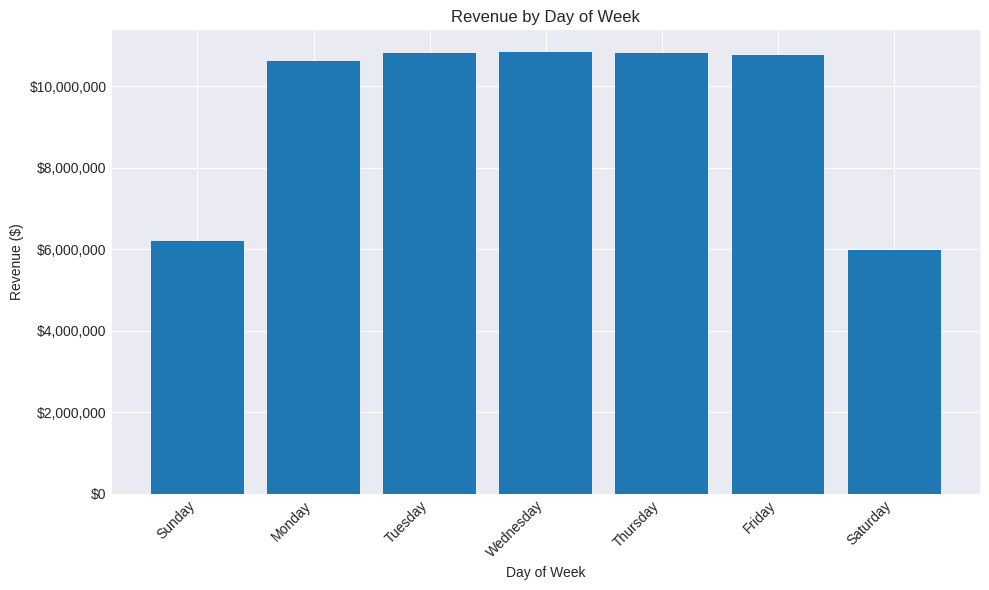


Revenue by Day of Week:


day_name,daily_revenue_$
str,str
"""Sunday""","""$6,207,799.00"""
"""Monday""","""$10,611,971.00"""
"""Tuesday""","""$10,814,455.00"""
"""Wednesday""","""$10,834,569.00"""
"""Thursday""","""$10,829,195.00"""
"""Friday""","""$10,758,715.00"""
"""Saturday""","""$5,981,489.00"""


In [ ]:
# Q1.4: Revenue by day of week
# Your code here

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Add day of week to orders
orders_with_day = orders.with_columns(
    pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S")
    .cast(pl.Date).dt.weekday().alias("day_of_week")
)

# Group revenue by day of week
revenue_by_day_of_week = (
    orders_with_day.group_by("day_of_week")
    .agg(pl.sum("order_total").alias("daily_revenue"))
    .with_columns(
        pl.col("day_of_week").replace_strict({
            1: "Monday", 2: "Tuesday", 3: "Wednesday",
            4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"
        }).alias("day_name")
    )
)

# Define Sunday-first ordering
week_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Build mapping {day_name: order_index} and sort
order_map = {day: i for i, day in enumerate(week_order)}
revenue_by_day_of_week = (
    revenue_by_day_of_week
    .with_columns(pl.col("day_name").replace_strict(order_map).alias("day_order"))
    .sort("day_order")
    .drop("day_order")
)

# --- PLOT BAR CHART ---
plt.figure(figsize=(10, 6))
plt.bar(revenue_by_day_of_week["day_name"], revenue_by_day_of_week["daily_revenue"])
plt.title("Revenue by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

# --- DISPLAY TABLE WITH FORMATTED REVENUE ---
def fmt_currency(x: float) -> str:
    return "${:,.2f}".format(x)

print("\nRevenue by Day of Week:")
display(
    revenue_by_day_of_week.with_columns(
        pl.col("daily_revenue").map_elements(fmt_currency, return_dtype=pl.Utf8)
        .alias("daily_revenue_$")
    ).select(["day_name", "daily_revenue_$"])
)

## Question 2: Product Performance

The Product Manager needs insights about the menu items:
- What is the revenue contribution of each product category (jaffles vs beverages)? (Store result in variable: `revenue_by_category`)
- What is the average price of products by type (jaffles vs beverages)?
- Include at least one chart to answer one of the above questions.


Revenue contribution by product category:


type,total_revenue_$
str,str
"""beverage""","""$39,836,200.00"""
"""jaffle""","""$22,880,900.00"""


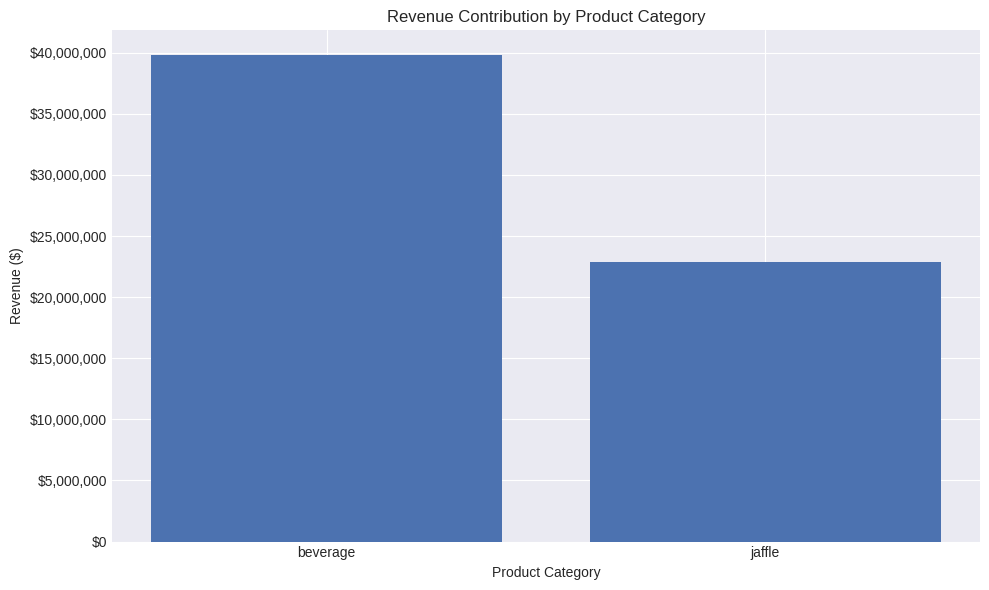

In [ ]:
# Q2.1: Revenue by product category
# Your code here

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Join items with products to get type and price
items_with_price = items.join(products.select(["sku", "type", "price"]), on="sku")

# Group by product type and sum the price to get revenue contribution
revenue_by_category = (
    items_with_price.group_by("type")
    .agg(pl.sum("price").alias("total_revenue"))
    .sort("total_revenue", descending=True)
)

# Helper function to format as currency
def fmt_currency(x: float) -> str:
    return "${:,.2f}".format(x)

# Display the result nicely
print("\nRevenue contribution by product category:")
display(
    revenue_by_category.with_columns(
        pl.col("total_revenue").map_elements(fmt_currency, return_dtype=pl.Utf8)
        .alias("total_revenue_$")
    ).select(["type", "total_revenue_$"])
)

# --- Bar Chart ---
plt.figure(figsize=(10, 6))
plt.bar(revenue_by_category["type"], revenue_by_category["total_revenue"], color="#4C72B0")
plt.title("Revenue Contribution by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

In [ ]:
# Q2.2 Average price of products by type
# Your code here

import polars as pl

# Q2.2: Average price of products by type
average_price_by_type = (
    products.group_by("type")
    .agg(pl.mean("price").alias("average_price"))
    .sort("average_price", descending=True)
)

# Helper function to format as currency
def fmt_currency(x: float) -> str:
    return "${:,.2f}".format(x)

# Display the result nicely
print("\nAverage Price by Product Type:")
display(
    average_price_by_type.with_columns(
        pl.col("average_price").map_elements(fmt_currency, return_dtype=pl.Utf8)
        .alias("average_price_$")
    ).select(["type", "average_price_$"])
)


Average Price by Product Type:


type,average_price_$
str,str
"""jaffle""","""$1,200.00"""
"""beverage""","""$560.00"""


## Question 3: Store Expansion Strategy

The Operations Director is planning expansion strategies:
- Which stores have the highest revenue per day since opening? (Store result in variable: `revenue_per_day_by_store`)
- What is the relationship between local tax rates and store performance? (Store result in variable: `tax_rate_performance`)
- Include at least one chart to answer one of the above questions.


Revenue per Day Since Opening by Store:


store_name,total_revenue_$,total_days_open,revenue_per_day_$
str,str,i64,str
"""Brooklyn""","""$22,822,628.00""",173,"""$131,922.71"""
"""Philadelphia""","""$43,215,565.00""",365,"""$118,398.81"""


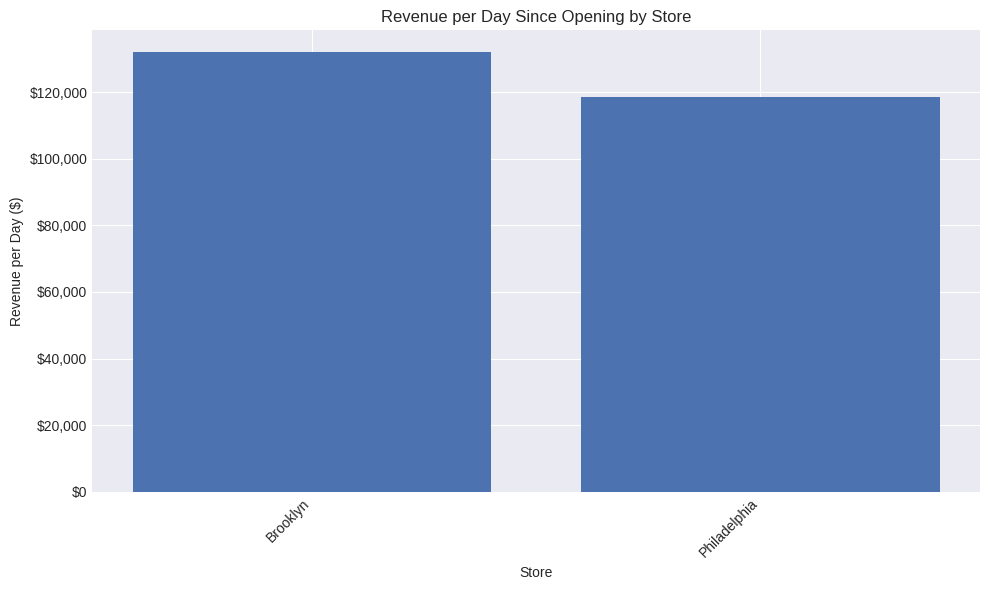

In [ ]:
# Q3.1: Revenue per day since opening by store
# Your code here

import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Helper function to format currency
def fmt_currency(x: float) -> str:
    return "${:,.2f}".format(x)

# Revenue per day since opening by store
revenue_per_day_by_store = (
    orders.join(stores.select(["id", "opened_at", "name"]), left_on="store_id", right_on="id")
    .with_columns([
        pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").alias("ordered_at_dt"),
        pl.col("opened_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").alias("opened_at_dt")
    ])
    .with_columns(
        ((pl.col("ordered_at_dt") - pl.col("opened_at_dt")).dt.total_days() + 1).alias("days_since_opening")
    )
    .group_by("store_id")
    .agg([
        pl.sum("order_total").alias("total_revenue"),
        pl.max("days_since_opening").alias("total_days_open"),
        pl.first("name").alias("store_name")
    ])
    .with_columns((pl.col("total_revenue") / pl.col("total_days_open")).alias("revenue_per_day"))
    .sort("revenue_per_day", descending=True)
)

# Display table
print("\nRevenue per Day Since Opening by Store:")
display(
    revenue_per_day_by_store.with_columns([
        pl.col("total_revenue").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("total_revenue_$"),
        pl.col("revenue_per_day").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("revenue_per_day_$")
    ]).select(["store_name", "total_revenue_$", "total_days_open", "revenue_per_day_$"]) # Moved select to here
)

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(revenue_per_day_by_store["store_name"], revenue_per_day_by_store["revenue_per_day"], color="#4C72B0")
plt.title("Revenue per Day Since Opening by Store")
plt.xlabel("Store")
plt.ylabel("Revenue per Day ($)")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

In [ ]:
# Q3.2: Tax rates vs store performance
# Your code here
tax_rate_performance = revenue_per_day_by_store.join(
    stores.select(["id", "tax_rate"]), left_on="store_id", right_on="id"
).with_columns(
    # divide instead of multiply
    (pl.col("revenue_per_day") / (1 + pl.col("tax_rate"))).alias("revenue_per_day_with_tax")
).select(
    ["store_name", "revenue_per_day", "tax_rate", "revenue_per_day_with_tax"]
).sort("tax_rate")

# Format nicely
tax_rate_performance = tax_rate_performance.with_columns([
    pl.col("revenue_per_day").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("revenue_per_day_$"),
    pl.format("{}%", (pl.col("tax_rate") * 100).round(2)).alias("tax_rate"),
    pl.col("revenue_per_day_with_tax").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("revenue_per_day_with_tax_$")
])

print("\nTax Rate vs Store Performance (Tax Deducted Revenue per Day):")
display(
    tax_rate_performance.select("store_name", "revenue_per_day_$", "tax_rate", "revenue_per_day_with_tax_$")
)


Tax Rate vs Store Performance (Tax Deducted Revenue per Day):


store_name,revenue_per_day_$,tax_rate,revenue_per_day_with_tax_$
str,str,str,str
"""Brooklyn""","""$131,922.71""","""4.0%""","""$126,848.76"""
"""Philadelphia""","""$118,398.81""","""6.0%""","""$111,696.99"""


## Question 4: Customer Behavior Analysis

The Marketing Manager wants to understand customer patterns:
- What is the distribution of order values? (Store result in variable: `order_value_distribution`)
- How many customers are repeat customers? (Store result in variable: `repeat_customer_analysis`)
- Which customers contribute the most to revenue? (Store result in variable: `top_revenue_customers`)

In [ ]:
# Q4.1: Distribution of order values
# Your code here
order_value_distribution = (
    orders.group_by("id")
         .agg(pl.col("order_total").sum().alias("order_value"))
)

# Summary statistics
order_value_summary = order_value_distribution.select([
    pl.col("order_value").min().alias("Min Order Value"),
    pl.col("order_value").max().alias("Max Order Value"),
    pl.col("order_value").mean().round(2).alias("Average Order Value"),
    pl.col("order_value").median().alias("Median Order Value"),
    pl.col("order_value").quantile(0.25).alias("25th Percentile"),
    pl.col("order_value").quantile(0.75).alias("75th Percentile")
])
order_value_summary = order_value_summary.with_columns(
    pl.col("Min Order Value").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("Min Order Value $"),
    pl.col("Max Order Value").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("Max Order Value $"),
    pl.col("Average Order Value").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("Average Order Value $"),
    pl.col("Median Order Value").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("Median Order Value $"),
    pl.col("25th Percentile").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("25th Percentile $"),
    pl.col("75th Percentile").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("75th Percentile $")
)
print("\nOrder Value Distribution Summary:")
display(
    order_value_summary.select("Min Order Value $", "Max Order Value $", "Average Order Value $", "Median Order Value $", "25th Percentile $", "75th Percentile $")
)


Order Value Distribution Summary:


Min Order Value $,Max Order Value $,Average Order Value $,Median Order Value $,25th Percentile $,75th Percentile $
str,str,str,str,str,str
"""$0.00""","""$10,281.00""","""$1,045.77""","""$636.00""","""$530.00""","""$1,165.00"""


In [ ]:
# Q4.2: Repeat customers analysis
# Your code here
repeat_customer_analysis = (
    orders.group_by("customer")
          .agg(pl.len().alias("order_count"))   # use pl.len() instead of pl.count()
          .with_columns((pl.col("order_count") > 1).alias("is_repeat"))
)

# Summary
repeat_summary = repeat_customer_analysis.select([
    pl.len().alias("Total_Customers"),
    pl.col("is_repeat").sum().alias("Repeat_Customers"),
    pl.format("{}%", (pl.col("is_repeat").sum() / pl.len() * 100).round(2)).alias("Repeat_Customer_Percentage")
])

print("\nRepeat Customer Analysis Summary:")
repeat_summary


Repeat Customer Analysis Summary:


Total_Customers,Repeat_Customers,Repeat_Customer_Percentage
u32,u32,str
930,920,"""98.92%"""


In [ ]:
# Q4.3: Top revenue contributors
# Your code here
orders_with_names = orders.join(customers.select(["id", "name"]), left_on="customer", right_on="id")

top_revenue_customers = (
    orders_with_names.group_by("customer", "name") # Group by customer and name
    .agg(pl.sum("order_total").alias("total_revenue"))
    .sort("total_revenue", descending=True)
    .head(5)
    .with_columns(
        # Cast to string and prepend dollar sign
        pl.col("total_revenue").map_elements(fmt_currency, return_dtype=pl.Utf8).alias("total_revenue_$")
    )
)

print("\nTop 5 Revenue Contributing Customers:")
display(
    top_revenue_customers.select(["name", "total_revenue_$"])
    )


Top 5 Revenue Contributing Customers:


name,total_revenue_$
str,str
"""David Leonard""","""$262,647.00"""
"""Jesse Moore""","""$259,037.00"""
"""Diane Davis""","""$258,515.00"""
"""Holly Johnson""","""$252,703.00"""
"""Gregory Hayes""","""$249,821.00"""


## Question 5: Profitability Deep Dive

The CEO needs a comprehensive profitability analysis:
- Calculate the gross margin for each product (consider supply costs) (Store result in variable: `product_margins`)
- Which products have the highest profit margins? (Store result in variable: `highest_margin_products`)
- What is the relationship between order size and profitability? (Store result in variable: `order_size_profitability`)
- How does profitability vary across different stores? (Store result in variable: `store_profitability`)

In [ ]:
# Q5.1: Calculate gross margin per product
# Join products with supplies to get supply costs per product
products_with_supplies = products.join(supplies, on="sku", how="left")

# Calculate total supply cost per product by summing costs for each SKU
total_supply_cost_per_product = products_with_supplies.group_by("sku").agg(
    pl.sum("cost").alias("total_supply_cost")
)

# Join products with the calculated total supply costs
products_with_cost = products.join(total_supply_cost_per_product, on="sku", how="left")

# Calculate gross margin per product (price - total_supply_cost)
# Handle cases where there might be no supply costs (fill with 0)
product_margins = products_with_cost.with_columns(
    (pl.col("price") - pl.col("total_supply_cost").fill_null(0)).alias("gross_margin")).sort("gross_margin", descending=True)


print("\nGross Margin per Product:")
# Display without complex currency formatting
display(product_margins.select(["sku", "name", "price", "total_supply_cost", "gross_margin"]))


Gross Margin per Product:


sku,name,price,total_supply_cost,gross_margin
str,str,i64,i64,i64
"""JAF-004""","""flame impala""",1400,343,1057
"""JAF-001""","""nutellaphone who dis?""",1100,121,979
"""JAF-005""","""mel-bun""",1200,239,961
"""JAF-002""","""doctor stew""",1100,251,849
"""JAF-003""","""the krautback""",1200,366,834
"""BEV-004""","""for richer or pourover """,700,82,618
"""BEV-001""","""tangaroo""",600,82,518
"""BEV-003""","""vanilla ice""",600,154,446
"""BEV-005""","""adele-ade""",400,63,337


In [ ]:
# Q5.2: Products with highest profit margins

# Helper function to format as currency
def fmt_currency(x: float) -> str:
    return "${:,.2f}".format(x)

# Q5.2: Products with highest profit margins
highest_margin_products = product_margins.sort("gross_margin", descending=True)

print("\nProducts with Highest Profit Margins:")
display(
    highest_margin_products
    .with_columns(
        pl.col("gross_margin").map_elements(fmt_currency, return_dtype=pl.Utf8)
        .alias("gross_margin_$")
    )
    .select(["sku", "name", "gross_margin_$"])
)


Products with Highest Profit Margins:


sku,name,gross_margin_$
str,str,str
"""JAF-004""","""flame impala""","""$1,057.00"""
"""JAF-001""","""nutellaphone who dis?""","""$979.00"""
"""JAF-005""","""mel-bun""","""$961.00"""
"""JAF-002""","""doctor stew""","""$849.00"""
"""JAF-003""","""the krautback""","""$834.00"""
"""BEV-004""","""for richer or pourover ""","""$618.00"""
"""BEV-001""","""tangaroo""","""$518.00"""
"""BEV-003""","""vanilla ice""","""$446.00"""
"""BEV-005""","""adele-ade""","""$337.00"""



Order Size vs Average Profitability:


order_size,average_profit_$
u32,str
1,"""$455.29"""
2,"""$1,260.72"""
3,"""$1,954.57"""
4,"""$2,755.95"""
5,"""$3,410.54"""
6,"""$4,150.05"""
8,"""$5,559.04"""
10,"""$6,885.32"""


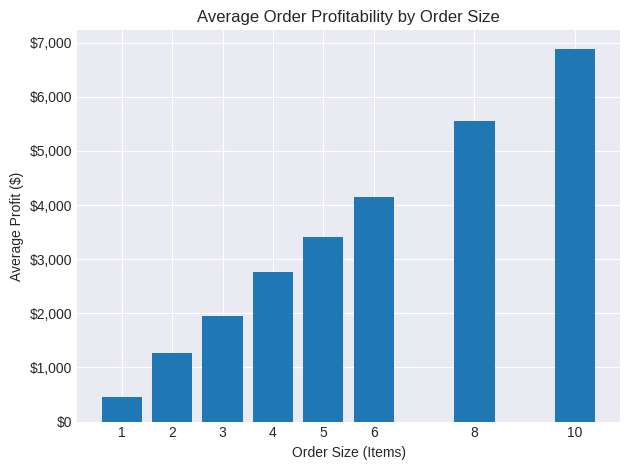

In [ ]:
# Q5.3: Order size vs profitability

def fmt_currency(x: float) -> str: return "${:,.2f}".format(x)

items_profit = (
    items.join(products, on="sku")
         .join(supplies.group_by("sku").agg(pl.sum("cost").alias("total_cost")), on="sku", how="left")
         .fill_null(0)
         .with_columns((pl.col("price") - pl.col("total_cost")).alias("item_profit"))
)

order_size_profitability = (
    items_profit.group_by("order_id")
        .agg([pl.sum("item_profit").alias("order_profit"), pl.len().alias("order_size")])
        .group_by("order_size")
        .agg(pl.mean("order_profit").alias("average_order_profit"))
        .sort("order_size")
        .with_columns(
            pl.col("average_order_profit").map_elements(fmt_currency, return_dtype=pl.Utf8)
            .alias("average_profit_$")
        )
)

print("\nOrder Size vs Average Profitability:")
display(order_size_profitability.select("order_size","average_profit_$")
)

# Chart
import matplotlib.pyplot as plt, matplotlib.ticker as mtick
plot_data = order_size_profitability.filter(pl.col("order_size") < 15)
plt.bar(plot_data["order_size"], plot_data["average_order_profit"])
plt.title("Average Order Profitability by Order Size")
plt.xlabel("Order Size (Items)"); plt.ylabel("Average Profit ($)")
plt.xticks(plot_data["order_size"]);
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout(); plt.show()

In [ ]:
# Q5.4: Profitability by store

def fmt_currency(x: float): return f"${x:,.2f}"

store_profitability = (
    orders.join(
        items.join(
            products.join(
                supplies.group_by("sku").agg(pl.sum("cost").alias("supply_cost")),
                on="sku", how="left"
            ).fill_null(0),
            on="sku"
        ),
        left_on="id", right_on="order_id"
    )
    .with_columns((pl.col("price") - pl.col("supply_cost")).alias("item_profit"))
    .group_by("store_id").agg(pl.sum("item_profit").alias("total_profit"))
    .join(stores.select(["id", "name"]), left_on="store_id", right_on="id")
    .with_columns(pl.col("total_profit").map_elements(fmt_currency, return_dtype=pl.Utf8)
    .alias("profit_$"))
    .sort("total_profit", descending=True)
)

print("\nProfitability by Store:")
display(store_profitability.select(["name", "profit_$"]))



Profitability by Store:


name,profit_$
str,str
"""Philadelphia""","""$32,358,060.00"""
"""Brooklyn""","""$17,408,441.00"""


## Question 6: Business Optimization Recommendations

Based on your analysis, provide three specific, data-driven recommendations to improve business performance. Support each recommendation with relevant metrics and visualizations.

### Recommendation 1: Focus on High-Performing Product Categories

**Recommendation:** Increase marketing and promotional efforts for beverage products.

**Rationale:** The analysis shows that beverages contribute significantly more to total revenue (`$39,836,200`) compared to jaffles (`$22,880,900`). Focusing on this higher-performing category can drive overall revenue growth.

**Supporting Metrics/Visualizations:** The revenue contribution by product category analysis (from Q2.1) clearly illustrates this difference.

### Recommendation 1: Unlocking Value from Small Basket Expansions (from 1 item to 2 items)
As order size increases, both beverages and jaffles generate much higher profits, but the biggest jumps happen at the start. Moving customers from 1 item to 2 items is the easiest way to see a drastic increase in profit. This means the easiest win is to encourage customers who typically buy just one product to add a second item. Simple marketing strategies like “add a drink for a discount” and bundles with prompts at checkout could capture the customer and boost profitability.

/tmp/ipython-input-1155840767.py:18: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(values="average_item_profit", index="order_size", columns="type")


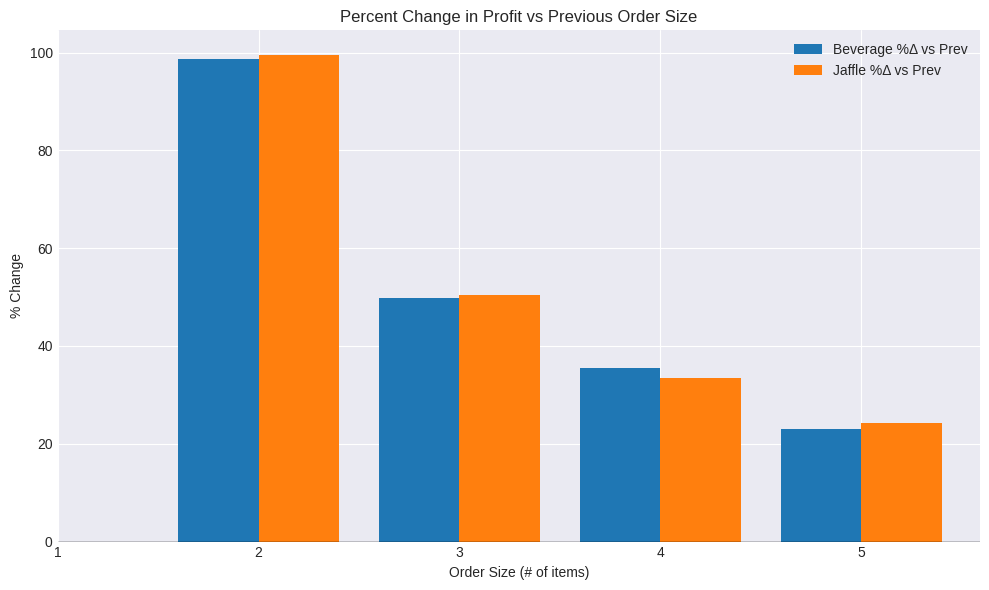

order_size,beverage,jaffle,beverage_pct_change,jaffle_pct_change
u32,f64,f64,f64,f64
1,449.630249,935.708994,null,null
2,893.245205,1867.371776,98.662169,99.567578
3,1338.641187,2807.578744,49.862678,50.349212
4,1813.075314,3745.966527,35.441471,33.423383
5,2230.656,4654.664,23.031624,24.258024


In [ ]:
# Supporting analysis for Recommendation 1
# Your code here
items_profit = (
    items.join(products, on="sku")
         .join(supplies.group_by("sku").agg(pl.sum("cost").alias("total_cost")), on="sku", how="left")
         .fill_null(0)
         .with_columns((pl.col("price") - pl.col("total_cost")).alias("item_profit"))
)
profitability_order_size_x_type = (
    items_profit.group_by("order_id", "type")
    .agg([
        pl.sum("item_profit").alias("order_profit"),
        pl.len().alias("order_size")
    ])
    .group_by("order_size", "type")
    .agg(pl.mean("order_profit").alias("average_item_profit"))
    .sort("order_size", "type")
    .pivot(values="average_item_profit", index="order_size", columns="type")
    .sort("order_size")
    .with_columns([
        (((pl.col("beverage") - pl.col("beverage").shift(1)) / pl.col("beverage").shift(1) * 100)
         .alias("beverage_pct_change")),
        (((pl.col("jaffle") - pl.col("jaffle").shift(1)) / pl.col("jaffle").shift(1) * 100)
         .alias("jaffle_pct_change"))
    ])
)


import numpy as np
x = np.arange(len(profitability_order_size_x_type["order_size"]))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, profitability_order_size_x_type["beverage_pct_change"], width, label="Beverage %Δ vs Prev")
plt.bar(x + width/2, profitability_order_size_x_type["jaffle_pct_change"], width, label="Jaffle %Δ vs Prev")
plt.title("Percent Change in Profit vs Previous Order Size")
plt.xlabel("Order Size (# of items)")
plt.ylabel("% Change")
plt.xticks(x, profitability_order_size_x_type["order_size"])
plt.axhline(0, color="black", linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

profitability_order_size_x_type

### Recommendation 2: Increase Weekend Sales to Match Weekday Sales
The business's daily revenue is significantly lower on the weekends (`$5,981,489.00` on Saturday and `$6,207,799.00` on Sunday) compared to weekdays (`$10,769,781.00` on average). Increasing sales on weekends to try and match sales on weekdays would make the business more profitable. Having specific products or deals on weekends could help with this increase.

If weekend sales matched weekday sales:
The current total revenue is: $66,038,193.00
The additional revenue if weekends matched weekdays would be: $9,350,274.00
The new total revenue would be: $75,388,467.00
This would mean that there is a % increase in revenue of: 14.16%


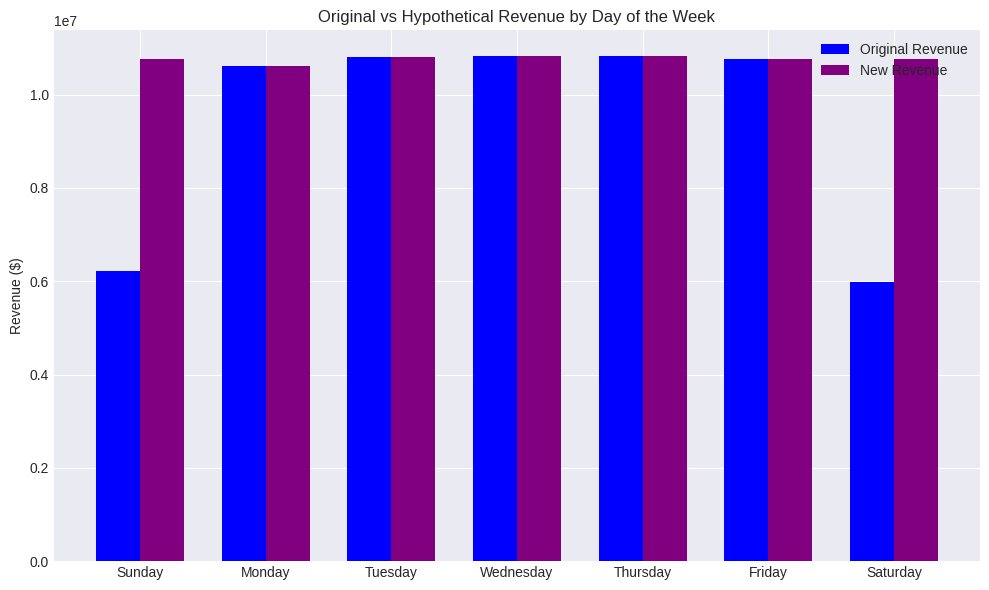

In [ ]:
# Supporting analysis for Recommendation 2
# Your code here

import numpy as np

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']

avg_weekday = revenue_by_day_of_week.filter(pl.col("day_name").is_in(weekdays)).select(pl.col("daily_revenue")).mean()
avg_weekend = revenue_by_day_of_week.filter(pl.col("day_name").is_in(weekends)).select(pl.col("daily_revenue")).mean()

new_revenue = revenue_by_day_of_week.with_columns(
    pl.when(pl.col("day_name").is_in(weekends)).then(avg_weekday).otherwise(pl.col("daily_revenue")).alias("new_daily_revenue")
)

original_total = revenue_by_day_of_week["daily_revenue"].sum()
new_total = new_revenue["new_daily_revenue"].sum()
additional_revenue = new_total - original_total
percentage_increase = (additional_revenue / original_total) * 100

print("If weekend sales matched weekday sales:")
print(f"The current total revenue is: ${original_total:,.2f}")
print(f"The additional revenue if weekends matched weekdays would be: ${additional_revenue:,.2f}")
print(f"The new total revenue would be: ${new_total:,.2f}")
print(f"This would mean that there is a % increase in revenue of: {percentage_increase:.2f}%")

days = revenue_by_day_of_week["day_name"].to_list()
original = revenue_by_day_of_week["daily_revenue"].to_list()
new = new_revenue["new_daily_revenue"].to_list()

x = np.arange(len(days))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, original, width, label='Original Revenue', color='blue')
rects2 = ax.bar(x + width/2, new, width, label='New Revenue', color='purple')

ax.set_ylabel('Revenue ($)') # Corrected ylabel
ax.set_title('Original vs Hypothetical Revenue by Day of the Week') # Corrected title
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.legend()
plt.tight_layout()
plt.show()

### Recommendation 3: Investing in Brooklyn’s growth while focusing on efficiency in Philadelphia.
Philadelphia’s revenue started steady but slowed down in the middle of the year, while Brooklyn kept growing and passed Philadelphia by the summer. This means Brooklyn is still growing fast, so the company should put more effort into expanding that store. Philadelphia, on the other hand, seems more stable, so it would make sense to focus on keeping profits strong through more cost savings as it already is very efficient with its costs when compared to Brooklyn.


Monthly Revenue Trends:


year,month,name,monthly_revenue_$,monthly_revenue_delta_$
i32,i8,str,str,str
2016,9,"""Philadelphia""","""$1,644,922.00""",null
2016,10,"""Philadelphia""","""$1,956,651.00""","""$311,729.00"""
2016,11,"""Philadelphia""","""$2,552,662.00""","""$596,011.00"""
2016,12,"""Philadelphia""","""$3,307,337.00""","""$754,675.00"""
2017,1,"""Philadelphia""","""$3,821,291.00""","""$513,954.00"""
…,…,…,…,…
2017,6,"""Brooklyn""","""$4,281,979.00""","""$-53,190.00"""
2017,7,"""Brooklyn""","""$4,626,219.00""","""$344,240.00"""
2017,7,"""Philadelphia""","""$3,959,101.00""","""$-667,118.00"""


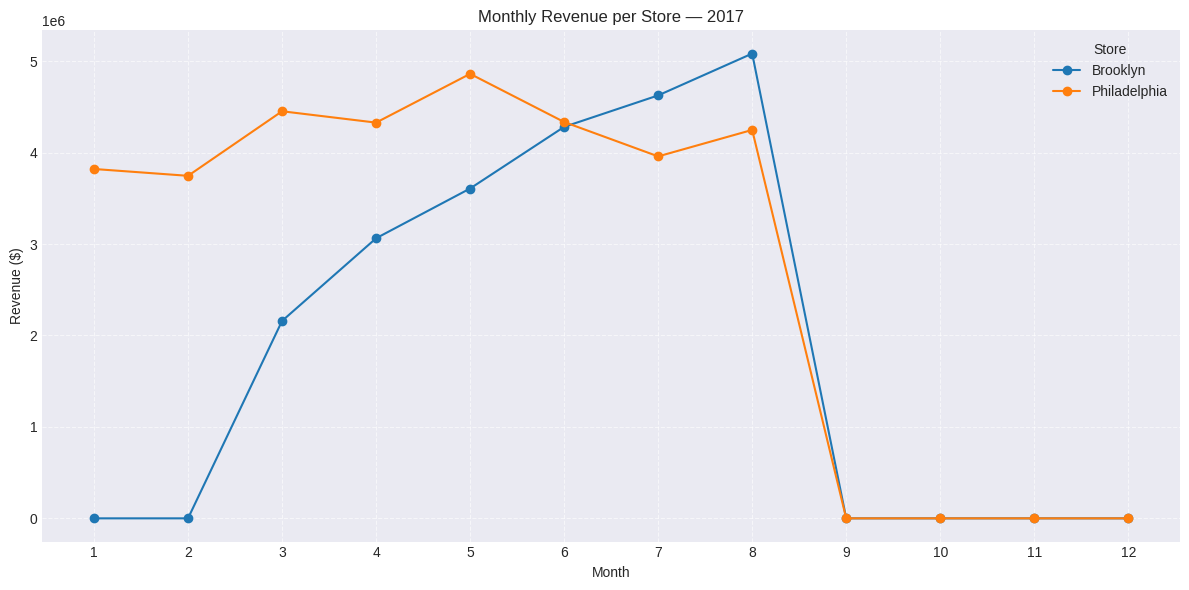

In [ ]:
# Supporting analysis for Recommendation 3
# Your code here
orders_with_month = orders.with_columns(pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").cast(pl.Date).alias("order_date"))

orders_with_store_info = orders_with_month.join(stores,left_on="store_id", right_on="id",how="left")

monthly_revenue_trends = (orders_with_store_info.group_by(pl.col("order_date").dt.year().alias("year"), pl.col("order_date").dt.month().alias("month"), pl.col("name"))
                          .agg(pl.sum("order_total").alias("monthly_revenue"))
                          .sort(["year", "month"])
                          .with_columns(pl.col("monthly_revenue").shift(1).alias("previous_monthly_revenue"))
                          .with_columns((pl.col("monthly_revenue") - pl.col("previous_monthly_revenue")).alias("monthly_revenue_change"))
                          .with_columns(
                              pl.col("monthly_revenue_change").map_elements(format_currency_polars, return_dtype=pl.Utf8).alias("monthly_revenue_delta_$")
                          )
)

print("\nMonthly Revenue Trends:")
display(
    monthly_revenue_trends.with_columns(
        pl.col("monthly_revenue").map_elements(format_currency_polars, return_dtype=pl.Utf8).alias("monthly_revenue_$"))
    .select(["year", "month", "name","monthly_revenue_$", "monthly_revenue_delta_$"]))

# Get the latest year
latest_year = monthly_revenue_trends["year"].max()

df_latest = (
    monthly_revenue_trends
    .filter(pl.col("year") == latest_year)
    .select(["year", "month", "name", "monthly_revenue"])
    .sort(["name", "month"])
)

# --- 3) Get all stores and months (1–12), fill missing with 0 ---
stores_unique = df_latest["name"].unique().to_list()
months = list(range(1, 13)) # Define months here

# --- 4) Plot each store as its own line ---
plt.figure(figsize=(12, 6))

for store in stores_unique:
    store_df = (
        pl.DataFrame({"month": months})
        .join(df_latest.filter(pl.col("name") == store), on="month", how="left")
        .with_columns(pl.col("monthly_revenue").fill_null(0)) # Fill null monthly_revenue with 0 for plotting
        .sort("month")
    )
    plt.plot(
        store_df["month"].to_list(),
        store_df["monthly_revenue"].to_list(),
        marker="o",
        label=store
    )

plt.title(f"Monthly Revenue per Store — {latest_year}")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.xticks(months)
plt.legend(title="Store")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# **Key Findings:**  

# Key Finding 1:
Expanding an order from one item to two leads to a significant increase in profit.  

Moving customers from 1 item to 2+ items produces a disproportionately larger lift in profit per order. Even modest add-ons (a drink, a side) materially expand contribution margin.  


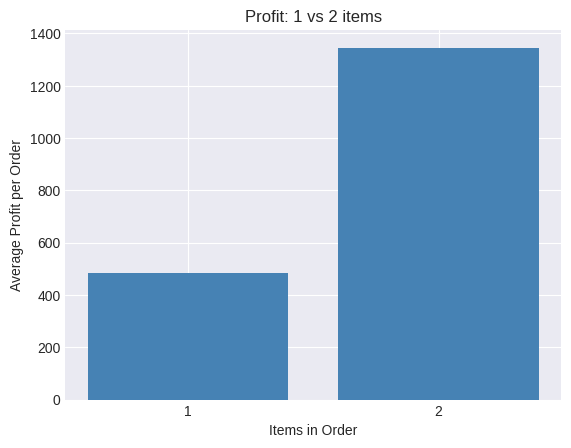

In [ ]:
rev = orders.select(["id","order_total"]).rename({"id":"order_id"})
cost = items.join(supplies.select(["sku","cost"]), on="sku", how="left").group_by("order_id").agg(pl.col("cost").sum().alias("total_cost"))
profit = rev.join(cost, on="order_id", how="left").with_columns((pl.col("order_total")-pl.col("total_cost")).alias("profit"))
basket_size = items.group_by("order_id").agg(pl.count("sku").alias("item_count"))
ol = profit.join(basket_size, on="order_id", how="inner")
bs = ol.group_by("item_count").agg(pl.col("profit").mean().alias("avg_profit")).sort("item_count")
show = bs.filter(pl.col("item_count").is_in([1,2]))

x = show["item_count"].to_list()
y = show["avg_profit"].to_list()

plt.bar(x, y, color="steelblue")
plt.xticks([1,2])
plt.xlabel("Items in Order")
plt.ylabel("Average Profit per Order")
plt.title("Profit: 1 vs 2 items")
plt.show()

# Key Finding 2:
Weekend sales underperform compared to weekdays.  
Average revenue on weekdays is nearly double that of weekends, revealing a clear gap. Closing this gap represents an opportunity to drive growth through targeted weekend offers and product bundles.

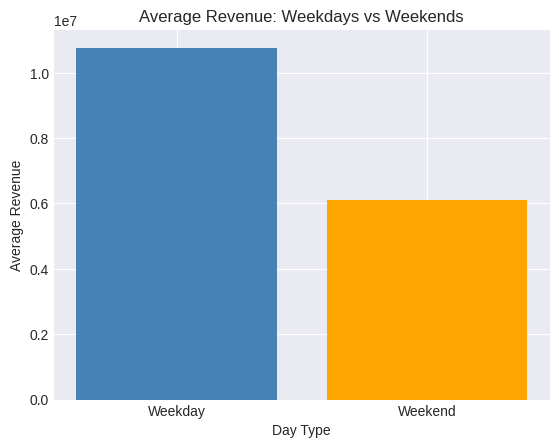

In [ ]:
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday']
weekends = ['Saturday','Sunday']

avg_weekday = revenue_by_day_of_week.filter(pl.col("day_name").is_in(weekdays)).select(pl.col("daily_revenue")).mean()[0,0]
avg_weekend = revenue_by_day_of_week.filter(pl.col("day_name").is_in(weekends)).select(pl.col("daily_revenue")).mean()[0,0]

x = ["Weekday","Weekend"]
y = [avg_weekday, avg_weekend]

plt.bar(x, y, color=["steelblue","orange"])
plt.xlabel("Day Type")
plt.ylabel("Average Revenue")
plt.title("Average Revenue: Weekdays vs Weekends")
plt.show()

# Key Finding 3:

Brooklyn showed stronger growth momentum than Philadelphia.
Although Philadelphia started out with higher revenue, its performance flattened as Brooklyn continued to rise and surpassed it midyear.

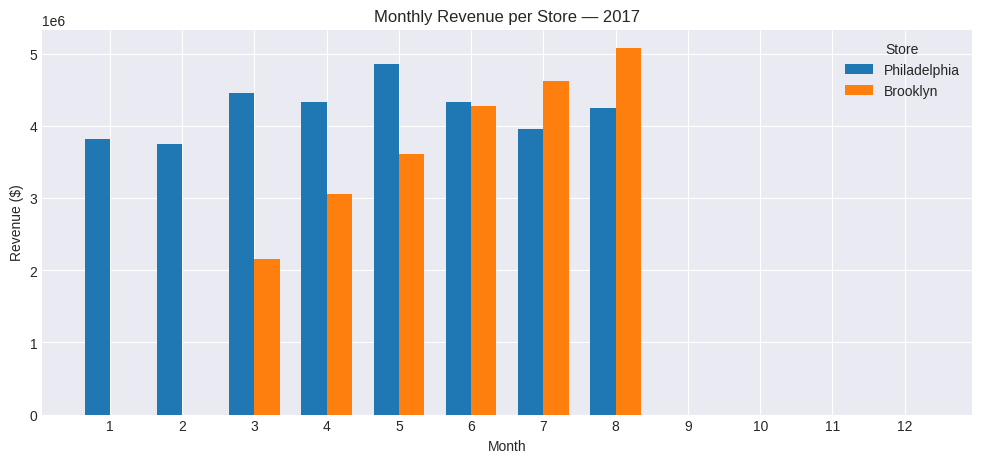

In [ ]:
yr = monthly_revenue_trends["year"].max()
base = (monthly_revenue_trends
        .filter(pl.col("year")==yr)
        .select(["month","name","monthly_revenue"]))
months = pl.DataFrame({"month": list(range(1,13))})
stores = ["Philadelphia","Brooklyn"]

dfs = []
for s in stores:
    sub = months.join(base.filter(pl.col("name")==s), on="month", how="left").fill_null(0).sort("month")
    sub = sub.rename({"monthly_revenue": s})
    dfs.append(sub)

m = dfs[0].join(dfs[1].select(["month","Brooklyn"]), on="month", how="left")
x = m["month"].to_list()
w = 0.35
idx = range(1,13)

plt.figure(figsize=(12,5))
plt.bar([i - w/2 for i in idx], m["Philadelphia"].to_list(), width=w, label="Philadelphia")
plt.bar([i + w/2 for i in idx], m["Brooklyn"].to_list(), width=w, label="Brooklyn")
plt.xticks(idx, x)
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.title(f"Monthly Revenue per Store — {yr}")
plt.legend(title="Store")
plt.show()

## Executive Summary

The Blue 7 Team conducted a comprehensive review of Jaffle Shop’s operations using Python Polars to analyze customer, order, product, supply, and store data. The analysis revealed several insights into Jaffle’s revenue drivers, customer behavior, store performance, and profitability.

The analysis concluded that Jaffle Shop generated `$66.04M` in total revenue across more than 63,000 orders and 90,000 items. Beverages represented the company’s cash cow, accounting for `$39.84M` in revenue. On the other hand, Jaffles only contributed to $22.88M. The data present that the beverages represented two/thirds of sales (60%).  

Furthermore, the revenue difference between weekdays and weekends was evident. Weekdays averaged `$10.77M`, compared to `$5.98M` on Saturday and `$6.21` M on Sunday. If weekend sales were to match weekday performance, overall revenue would increase by roughly $9.35M, or 14%.

Moreover, it was established that profitability disproportionately grows with order size. The most significant jump occurs when customers expand from one item to two, especially when adding a beverage. Nonetheless, looking at the store side, performance varied. Brooklyn displayed consistent growth and overtook Philadelphia by mid year, while Philadelphia plateaued.

Based on the key findings, the team developed three strategic recommendations.
1) Encouraging customers to increase basket size by moving from one item to two through bundles, cross selling, and targeted promotions.
2) Implementing weekend campaigns; ranging from brunch specials and family packs, to close the gap between weekend and weekday sales. Potentially generating additional $9.35M in revenue.
3) Prioritizing growth investment in Brooklyn, given its strong trajectory, while focusing on efficiency and cost management in Philadelphia, where performance has stabilized.
In conclusion, the final analysis is supported by visualizations and scenario tests; thus, providing a clear roadmap for enhancing profitability, balancing store performance, and sustaining long term growth for Jaffle Shop.


### Key Findings:
1. Expanding an order from one item to two leads to a significant increase in profit.
2. Weekend sales underperform compared to weekdays.
3. Brooklyn shows stronger growth momentum than Philadelphia.

### Strategic Recommendations:
1. Unlocking Value from Small Basket Expansions
2. Increase Weekend Sales to Match Weekday Sales
3. Investing in Brooklyn's growth while focusing on efficiency in Philadelphia.